<b>Problem Statement</b><br>
If I were a real estate developer I would be interested in aggregating multiple sources of listing and mortgage data in a specific neighborhood, correlating to the larger market and using this to identify the most opportune time to sell assets and re-capitalize. In simpler terms, I want to know if we are approaching another market peak and the opportune time to sell.

<b>Data Sources</b> <br>
- Zillow - Sales data by zip code per month<br>
  Source:
- Case Shiller - 10 City Index per quarter<br>
  Source:
- NYC Open Data - Department of Buuildings Permit Issuances<br>
  Source:

In [44]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

I chose to load the csv data as Pandas dataframe to make selecting and slicing simpler. 

In [26]:
casedf = pd.read_csv('~/Downloads/SPCS10RSA.csv')
zillowdf = pd.read_csv('~/Downloads/Zip_Zhvi_AllHomes.csv')
print casedf.info()
print zillowdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 0 to 114
Data columns (total 2 columns):
DATE     115 non-null object
VALUE    115 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13058 entries, 0 to 13057
Columns: 242 entries, RegionID to 2015-10
dtypes: float64(201), int64(37), object(4)
memory usage: 24.2+ MB
None


The Case-Shiller data looks to be "long", with two columns representing the quarter and the aggregated city values. The Zillow data on the other hand has numerous columns which represent months horizontally, adding to this there are some missing values

In [28]:
print casedf.head()
print zillowdf.head()

         DATE  VALUE
0  1987-01-01  63.78
1  1987-04-01  65.79
2  1987-07-01  67.73
3  1987-10-01  69.62
4  1988-01-01  71.25
   RegionID  RegionName      City State                               Metro  \
0     62080       11368  New York    NY                            New York   
1     93144       79936   El Paso    TX                             El Paso   
2     84630       60629   Chicago    IL                             Chicago   
3     96193       90650   Norwalk    CA  Los Angeles-Long Beach-Anaheim, CA   
4     62037       11226  New York    NY                            New York   

    CountyName  SizeRank  1996-04  1996-05  1996-06   ...     2015-01  \
0       Queens         1      NaN      NaN      NaN   ...      353200   
1      El Paso         2    70800    71000    71000   ...      111500   
2         Cook         3    93100    93100    92900   ...      134300   
3  Los Angeles         4   144500   144300   143900   ...      373300   
4        Kings         5      NaN 

To begin with, I first changed the DATE column in the Case-Shiller dataframe to be datetime

In [29]:
casedf['DATE'] = pd.to_datetime(casedf['DATE'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 0 to 114
Data columns (total 2 columns):
DATE     115 non-null datetime64[ns]
VALUE    115 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.7 KB
None


Slice to get just the values that are needed for the analysis. In this case data from 2010 on.

In [30]:
casedf = casedf.ix[92:]
print casedf

          DATE   VALUE
92  2010-01-01  159.68
93  2010-04-01  160.14
94  2010-07-01  158.82
95  2010-10-01  156.82
96  2011-01-01  155.42
97  2011-04-01  153.99
98  2011-07-01  153.14
99  2011-10-01  151.03
100 2012-01-01  149.92
101 2012-04-01  152.15
102 2012-07-01  155.13
103 2012-10-01  158.20
104 2013-01-01  162.82
105 2013-04-01  169.60
106 2013-07-01  174.91
107 2013-10-01  179.95
108 2014-01-01  184.07
109 2014-04-01  185.44
110 2014-07-01  184.83
111 2014-10-01  187.54
112 2015-01-01  192.26
113 2015-04-01  193.88
114 2015-07-01  193.70


Now, on to the Zillow data. As mentioned, the raw data is in "wide" format where the variables (columns) are in month increments and the observations (rows) are the neighborhoods by zip code. For linear regression the n, number of observations, for both the x and y values have to be same. To begin, I dropped the columns not needed (in this case the values were coincidentally not present up till 2010), selected the one "row" that matched to Long Island City (zip code 11101), and then transposed the data to match the "long" format of the Case-Shiller data and also for plotting.

In [31]:
colcounter = range(0, 172)
licdata = zillowdf.drop(zillowdf.columns[[colcounter]], axis=1)
licdata = licdata[2998:2999].T

The other complication with the Zillow data is that it was by month, and the Case-Shiller data is by quarter. When data gives you lemons, you make lemonade. The following code droppped the columns I did not need.

In [32]:
excludelist = []
years = ['2010', '2011', '2012', '2013', '2014', '2015']
months = ['02', '03', '05', '06', '08', '09', '11', '12']
for i in years:
    for j in months:
        excludelist.append(str(i) + "-" + str(j))
# manually dropping the last two months in 2015 as they are not present in the data
del excludelist[-2:]
licdata = licdata.drop(excludelist, axis=0)
licdata = licdata.ix[:-1]
print licdata

           2998
2010-01  493800
2010-04  541400
2010-07  590000
2010-10  620100
2011-01  635800
2011-04  625800
2011-07  614000
2011-10  593000
2012-01  569900
2012-04  568000
2012-07  619100
2012-10  630300
2013-01  643800
2013-04  651500
2013-07  670600
2013-10  734800
2014-01  802500
2014-04  787700
2014-07  766100
2014-10  793700
2015-01  791700
2015-04  751400
2015-07  675600


And yet another wrinkle is that the scale of the Case-Shiller data was format shortened by decimal (common with large amounts in Finance), where the Zillow Data was actual. I shifted the decimal and then "squeezed" both dataframes to ensure that they would be able to be plotted.

In [33]:
Y = np.array(licdata[[2998]])
Y = Y/1000
Y = Y.squeeze()
print Y.shape
X = np.array(casedf[['VALUE']])
X = X.squeeze()
print X.shape

(23,)
(23,)


Finally, the linear regression available through SciPy

In [48]:
slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
print "Slope: ", slope
print "R-value: ", r_value

Slope:  4.77832659201
R-value:  0.843670354844


The r_value is 0.8437, close to 1. This indicates that there is a strong linear relationship between x - case-shiller 10-city index data, and y - residential sales data for Long Island City, NY (zip 11101). As the prices increase in x, they also increase on y.<br>
This isn't entirely surprising, as New York City is one of the cities where its real estate sales data is used to create the Case-Shiller index. What was unexpected was how strong this relationship was. A long-time argument with developers in New York City

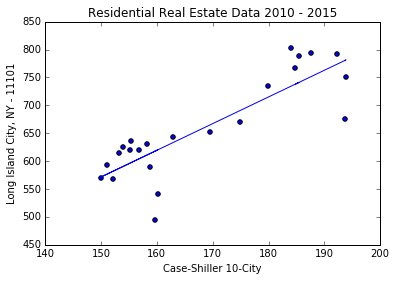

In [45]:
plt.scatter(X, Y)
plt.plot(X, slope*X + intercept)
plt.ylabel('Long Island City, NY - 11101')
plt.xlabel('Case-Shiller 10-City')
plt.title('Residential Real Estate Data 2010 - 2015')
plt.show()

<b>Analysis 1 - Strong correlation of Long Island City Residential Sales to the larger market</b><br>
The plot of the data, along with the regression line demonstrating the r-value of 0.8437 and a strong correlation indicates that sales in this neighborhood generally follows the trend of the larger market place. This answers the first part of the problem statement.<br><br>
Next, we take a look at the Case-Shiller index on a longer timescale (2000-2015) to determine if it is approaching another high.

In [50]:
casedf = pd.read_csv('~/Downloads/SPCS10RSA.csv')
casedf = casedf.ix[52:]
casedf['DATE'] = pd.to_datetime(casedf['DATE'])
X = np.array(casedf[['DATE']])
Y = np.array(casedf[['VALUE']])
X = X.squeeze()
Y = Y.squeeze()

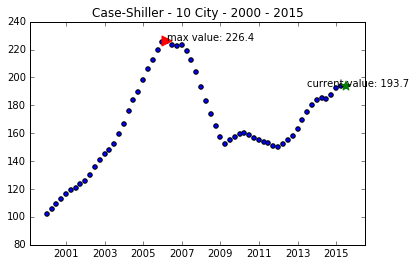

In [53]:
maxYvalue = max(Y)
maxresult = casedf.loc[casedf['VALUE'] == maxYvalue]
current = Y[-1]
dx = maxresult[['DATE']].squeeze()
plt.scatter(X, Y)
plt.scatter(dx, maxYvalue, color='red', marker='>', s=100)
plt.annotate('max value: %s' % maxYvalue, xy=(dx, maxYvalue))
plt.scatter('2015-07-01 00:00:00', current, color='green', marker='*', s=100)
plt.annotate('current value: %s' % current, xy=('2013-07-01 00:00:00', current))
plt.title('Case-Shiller - 10 City - 2000 - 2015')
plt.show()

<b>Analysis 2 - Market approaching peak</b><br>
As you can see from the plot, the max value according to the Case-Shiller index was 226,400 right before the market popped in 2008 and the last set of data for 2015 was 193,700. This, along with the shape of the graph from 2012 on indicate that prices are indeed on the rise again and likely heading to another peak. <br><br>
However, predicting any market using trailing data is next to impossible. There is just too much variability in the world for it to be accurate using trailing data indicators as a basis for decision making. There may be a data variable available that can help due to natural lag in the process. Building Permit applications.<br>
In New York City, all real estate developers or contractors that want to perform work need to submit applications to the Department of Buildings. NYC Open Data does capture some of this information that we might be able to use to determine if there is an increase in applications, vis-a-vis an increase in development ultimately driving prices up.